## Demonstration of ETS and SARIMA forecasting models

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bsestyle_light')
import numpy as np
import pandas as pd

import ets as ets_m
import arima as arima_m

### ETS
I have modified the HoltWinters Additive, and Multiplicative algorithms in order to provide prediction intervals along with our forecasts. ETS models give the same point forecasts as HW, but the addition of error terms (and some reorganization of the equations) allows us to specify forecast variances and thus prediction intervals.

In [19]:
# Initialize and get some test data
ets = ets_m.ETS()
yt = ets.load_test_data('simple')

# Set seasonality and forecast horizon
season = 12
horizon = 12

# Fit some models
ft, pred_int = ets.ETS_AAA(yt=yt, season=season, horizon=horizon, method='ll')
aaa_params = ets.params

ft_m, pred_int_m = ets.ETS_MAM(yt=yt, season=season, horizon=horizon, method='ll')
mam_params = ets.params

[0.9060516  0.         0.59479833]
[0.00312466 0.00205004 1.        ]


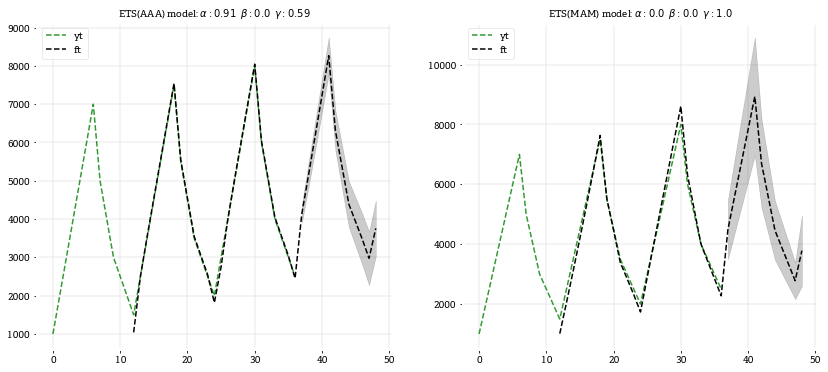

In [20]:
def get_params(params):
    params = params[0]
    alpha = params[0]
    beta = params[1]
    gamma = params[2]
    
    return (round(alpha, 2), round(beta, 2), round(gamma, 2))
    
ind = np.arange(len(yt) + horizon)

fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(yt, 'g--', alpha=0.8, label='yt')
ax.plot(ft, 'k--', label='ft')
ax.fill_between(ind, pred_int[0], pred_int[1], color='k', alpha=.2)
params = get_params(aaa_params)
ax.set_title(r"ETS(AAA) model: $\alpha: {}$  $\beta: {}$  $\gamma: {}$".format(params[0], params[1], params[2]))
ax.legend(loc='upper left')

ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(yt, 'g--', alpha=0.8, label='yt')
ax1.plot(ft_m, 'k--', label='ft')
ax1.fill_between(ind, pred_int_m[0], pred_int_m[1], color='k', alpha=.2)
params = get_params(mam_params)
ax1.set_title(r"ETS(MAM) model: $\alpha: {}$  $\beta: {}$  $\gamma: {}$".format(params[0], params[1], params[2]))
ax1.legend(loc='upper left')

### SARIMA
ARIMA models can also be modelled in state space form. I make use of statsmodels backend to run these models, and implemented some optimization logic to find optimal models (brute force all combinations (p, q, P, D, Q | d) and take minimum AIC).

In [21]:
# Disable convergence warnings

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

    yt = ets.load_test_data('complex')
    mod = arima_m.ARIMA(yt=yt, mtype='S', pmax=3, qmax=3, s_pmax=2, s_qmax=2, seasonality=12)
    res = mod.fit()

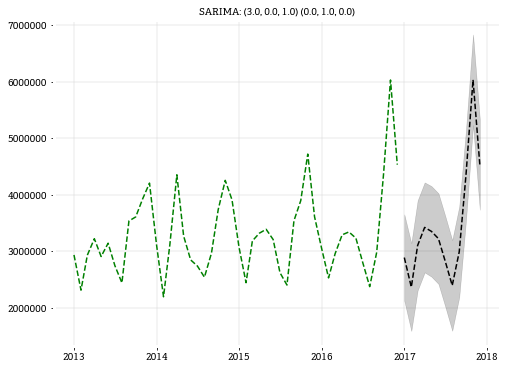

In [22]:
# Predictions + intervals
preds = res.get_prediction(start=len(yt), end=len(yt) + 11, dynamic=True)
pred_ci = preds.conf_int(alpha=0.05)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(yt, 'g--', label='yt')
ax.plot(preds.predicted_mean, 'k--', label='ft') # ft
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
p, d, q, P, D, Q = mod.opt_params
t = ax.set_title('SARIMA: ({}, {}, {}) ({}, {}, {})'.format(p, d, q, P, D, Q))